# Projet Datascientest - Compagnon immo

<code>mar25_bds_compagnon_immo_1</code>


---

## Modélisation évolution des prix - v2.0

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip

from tabulate import tabulate

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

### Chargement des données nettoyées

In [35]:
output_path = '../data/processed/dep_75_cleaned.csv.gz'
df_dep75 = pd.read_csv(output_path, low_memory=False, index_col='date_mutation', parse_dates=True)

### Deep Learning

#### Train test Split

In [41]:
df_dep75['log_valeur_fonciere'] = np.log(df_dep75['valeur_fonciere'])
df_dep75['log_prix_m2_vente'] = np.log(df_dep75['prix_m2_vente'])

df_train = df_dep75[df_dep75['annee'] < 2024]
df_test = df_dep75[df_dep75['annee'] == 2024]

X_train = df_train.drop(['prix_m2_vente', 'log_prix_m2_vente'], axis=1)
X_test = df_test.drop(['prix_m2_vente', 'log_prix_m2_vente'], axis=1)

y_train_log = df_train['log_prix_m2_vente']
y_test_log = df_test['log_prix_m2_vente']

#### Encodage

In [45]:
one_hot_cols = ['type_local', 'nature_mutation']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[one_hot_cols])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[one_hot_cols]), 
                           columns=ohe.get_feature_names_out(one_hot_cols),
                           index=X_train.index)

X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                          columns=ohe.get_feature_names_out(one_hot_cols),
                          index=X_test.index)

X_train = X_train.drop(columns=one_hot_cols)
X_test = X_test.drop(columns=one_hot_cols)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

freq_cols = ['code_nature_culture', 'code_nature_culture_speciale', 'code_commune', 'code_departement']

for col in freq_cols:
    freq_encoding = X_train[col].value_counts(normalize=True)

    X_train[col] = X_train[col].map(freq_encoding).fillna(0)
    X_test[col] = X_test[col].map(freq_encoding).fillna(0)

for i in range(1, 6):
    col = f'lot{i}_numero'
    X_train[col] = (X_train[col] != 0).astype(int)
    X_test[col] = (X_test[col] != 0).astype(int)

print("Variables catégorielles restantes :", len(X_train.select_dtypes('object').columns))

Variables catégorielles restantes : 0


#### Standardisation

In [17]:
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#### Callbacks

In [127]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
]

In [86]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train["prix_m2_vente"].values.reshape(-1, 1))
df_test_scaled = scaler.transform(df_test["prix_m2_vente"].values.reshape(-1, 1))

def create_sequences(data, timesteps=12):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 12
X_train, y_train = create_sequences(df_train_scaled, timesteps)
X_test, y_test = create_sequences(df_test_scaled, timesteps)

model_gru = Sequential([
    GRU(50, activation="relu", return_sequences=False, input_shape=(timesteps, 1)),
    Dense(1)
])

model_gru.compile(optimizer="adam", loss="mse")
model_gru.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)


y_pred_gru = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1482/1482 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 2/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 3/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.8783e-04 - val_loss: 0.0028
Epoch 4/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 5/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.3703e-04 - val_loss: 0.0028
Epoch 6/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 7/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 8/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.2640e-04 - val_loss: 0.0028
Epoch 9/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 10/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.2028e-04 - val_loss: 0.0028
Epoch 11/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 12/50
1482/1482 ━━━

In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
prix_m2_test_actual = df_test["prix_m2_vente"].values[timesteps:]

mae = mean_absolute_error(prix_m2_test_actual, y_pred_gru)
rmse = np.sqrt(mean_squared_error(prix_m2_test_actual, y_pred_gru))
r2 = r2_score(prix_m2_test_actual, y_pred_gru)

scores_gru = pd.DataFrame([{
    'Modèle': 'GRU',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}])
display(scores_gru)

,Modèle,MAE,RMSE,R2
0,GRU,283360.206198,1.212434e+06,0.009431


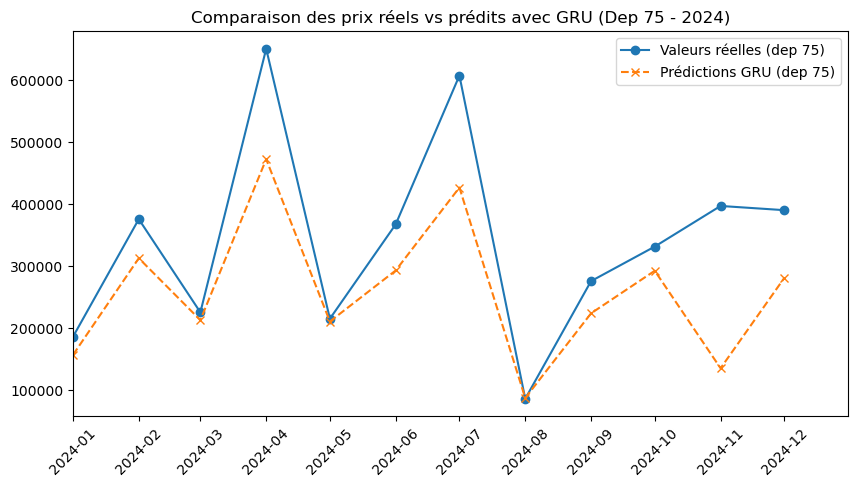

In [90]:
df_test_trimmed = df_test.iloc[timesteps:].copy()
df_test_trimmed["pred_gru"] = y_pred_gru.flatten()

df_monthly = df_test_trimmed.select_dtypes(include='number').resample('MS').mean()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly["prix_m2_vente"], label="Valeurs réelles (dep 75)", marker="o")
plt.plot(df_monthly.index, df_monthly["pred_gru"], label="Prédictions GRU (dep 75)", linestyle="dashed", marker="x")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec GRU (Dep 75 - 2024)")
plt.xticks(rotation=45)
plt.show();

#### LSTM

In [68]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    LSTM(100, activation="relu", return_sequences=True, input_shape=(timesteps, df_train_scaled.shape[1])),
    LSTM(50, activation="relu", return_sequences=False),
    Dense(1)
])


# Compilation et entraînement
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1482/1482 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0012 - val_loss: 1632356270080.0000
Epoch 2/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011 - val_loss: 1632356270080.0000
Epoch 3/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014 - val_loss: 1632356270080.0000
Epoch 4/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0011 - val_loss: 1632356270080.0000
Epoch 5/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011 - val_loss: 1632356270080.0000
Epoch 6/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011 - val_loss: 1632356270080.0000
Epoch 7/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0012 - val_loss: 1632356270080.0000
Epoch 8/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014 - val_loss: 1632356270080.0000
Epoch 9/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011 - val_loss: 1632356270080.0000
Epoch 10/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0012 - val_loss: 1632356270080.0000
Epoch 11/5

,Modèle,MAE,RMSE,R2
0,LSTM,331196.593762,1.207558e+06,0.017383


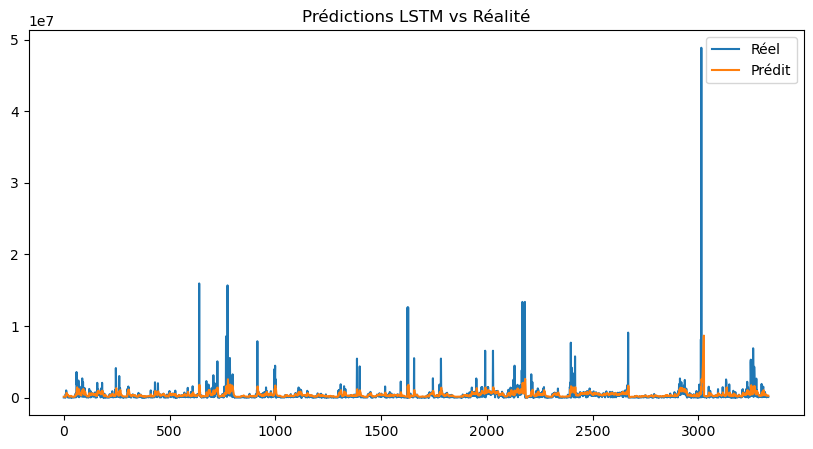

In [108]:
prix_m2_test_actual = df_test["prix_m2_vente"].values[timesteps:]

mae = mean_absolute_error(prix_m2_test_actual, y_pred_lstm)
rmse = np.sqrt(mean_squared_error(prix_m2_test_actual, y_pred_lstm))
r2 = r2_score(prix_m2_test_actual, y_pred_lstm)

scores_lstm = pd.DataFrame([{
    'Modèle': 'LSTM',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}])
display(scores_lstm)

plt.figure(figsize=(10, 5))
plt.plot(prix_m2_test_actual, label="Réel")
plt.plot(y_pred_lstm, label="Prédit")
plt.legend()
plt.title("Prédictions LSTM vs Réalité")
plt.show();

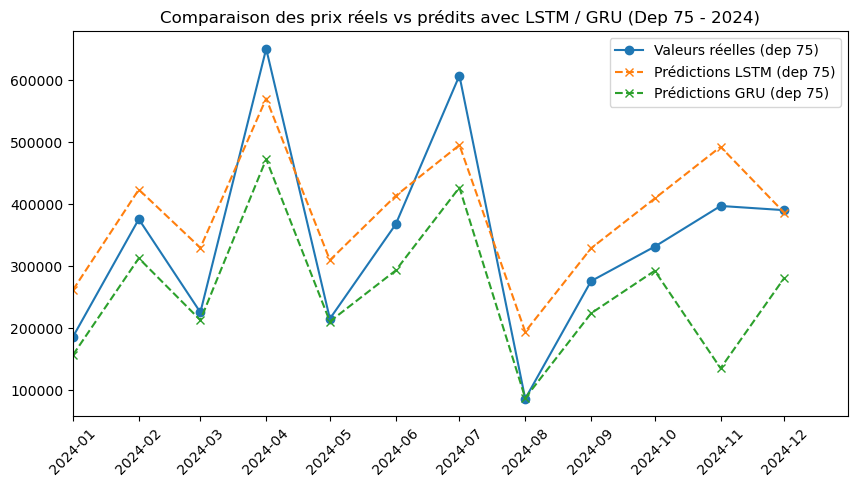

In [98]:
df_test_trimmed = df_test.iloc[timesteps:].copy()
df_test_trimmed["pred_lstm"] = y_pred_lstm.flatten()
df_test_trimmed["pred_gru"] = y_pred_gru.flatten()

df_monthly = df_test_trimmed.select_dtypes(include='number').resample('MS').mean()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly["prix_m2_vente"], label="Valeurs réelles (dep 75)", marker="o")
plt.plot(df_monthly.index, df_monthly["pred_lstm"], label="Prédictions LSTM (dep 75)", linestyle="dashed", marker="x")
plt.plot(df_monthly.index, df_monthly["pred_gru"], label="Prédictions GRU (dep 75)", linestyle="dashed", marker="x")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec LSTM / GRU (Dep 75 - 2024)")
plt.xticks(rotation=45)
plt.show();

#### Optimisation GRU

In [118]:
from tensorflow.keras.layers import Bidirectional

model_gru_opt = Sequential([
    Bidirectional(GRU(128, activation="relu", return_sequences=True, input_shape=(timesteps, 1))),
    GRU(64, activation="relu", return_sequences=False),
    Dense(1)
])

model_gru_opt.compile(optimizer="Adam", loss="mse")

model_gru_opt.fit(X_train, y_train, epochs=300, batch_size=4, validation_data=(X_test, y_test), verbose=1)

y_pred_gru_opt = model_gru_opt.predict(X_test)
y_pred_gru_opt = scaler.inverse_transform(y_pred_gru_opt.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))   

Epoch 1/300


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2964/2964 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0011 - val_loss: 1632356532224.0000
Epoch 2/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0013 - val_loss: 1632356532224.0000
Epoch 3/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0014 - val_loss: 1632356532224.0000
Epoch 4/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0012 - val_loss: 1632356532224.0000
Epoch 5/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0012 - val_loss: 1632356532224.0000
Epoch 6/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0010 - val_loss: 1632356532224.0000
Epoch 7/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0012 - val_loss: 1632356532224.0000
Epoch 8/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0012 - val_loss: 1632356532224.0000
Epoch 9/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0011 - val_loss: 1632356532224.0000
Epoch 10/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0011 - val_loss: 1632356532

In [123]:
prix_m2_test_actual = df_test["prix_m2_vente"].values[timesteps:]

mae = mean_absolute_error(prix_m2_test_actual, y_pred_gru_opt)
rmse = np.sqrt(mean_squared_error(prix_m2_test_actual, y_pred_gru_opt))
r2 = r2_score(prix_m2_test_actual, y_pred_gru_opt)

scores_gru_opt = pd.DataFrame([{
    'Modèle': 'GRU Optimisé',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}])
display(scores_gru_opt)

,Modèle,MAE,RMSE,R2
0,GRU Optimisé,344284.385838,1.419728e+06,-0.358247


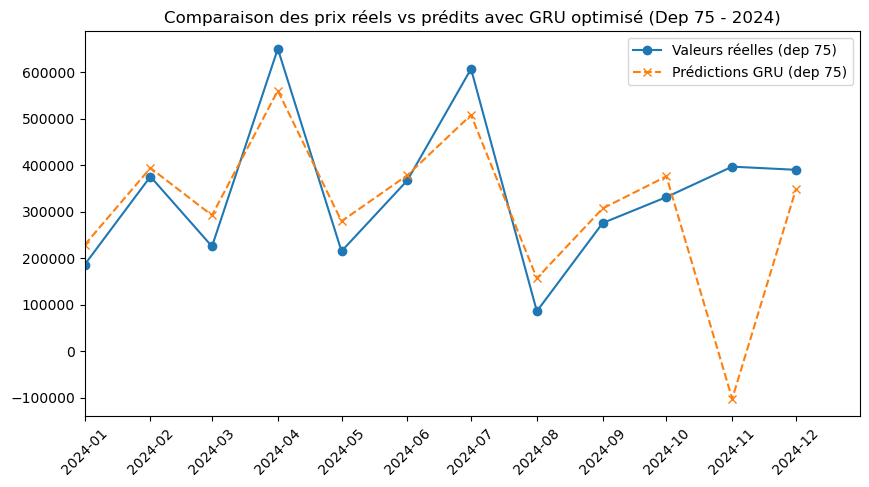

In [125]:
df_test_trimmed = df_test.iloc[timesteps:].copy()
df_test_trimmed["pred_gru_opt"] = y_pred_gru_opt.flatten()

df_monthly = df_test_trimmed.select_dtypes(include='number').resample('MS').mean()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly["prix_m2_vente"], label="Valeurs réelles (dep 75)", marker="o")
plt.plot(df_monthly.index, df_monthly["pred_gru_opt"], label="Prédictions GRU (dep 75)", linestyle="dashed", marker="x")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec GRU optimisé (Dep 75 - 2024)")
plt.xticks(rotation=45)
plt.show();

In [129]:
model_lstm_opt = Sequential([
    Bidirectional(LSTM(128, activation="relu", return_sequences=True, input_shape=(timesteps, 1))),
    LSTM(64, activation="relu", return_sequences=False),
    Dense(1)
])

model_lstm_opt.compile(optimizer="Adam", loss="mse")
model_lstm_opt.fit(X_train, y_train, epochs=300, batch_size=4, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)

y_pred_lstm_opt = model_lstm_opt.predict(X_test)
y_pred_lstm_opt = scaler.inverse_transform(y_pred_lstm_opt.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))   

Epoch 1/300


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2964/2964 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0012 - val_loss: 814182688802721467425882112.0000 - learning_rate: 0.0010
Epoch 2/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0013 - val_loss: 814182688802721467425882112.0000 - learning_rate: 0.0010
Epoch 3/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 9.4276e-04 - val_loss: 814182688802721467425882112.0000 - learning_rate: 0.0010
Epoch 4/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0015 - val_loss: 814182688802721467425882112.0000 - learning_rate: 0.0010
Epoch 5/300
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0011 - val_loss: 814182688802721467425882112.0000 - learning_rate: 0.0010
Epoch 6/300
2963/2964 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0014 - val_loss: 814182688802721467425882112.0000 - learning_rate: 0.0010
Epoch 7/300
2964/2964 ━━━━━━━━━━━━

In [136]:
prix_m2_test_actual = df_test["prix_m2_vente"].values[timesteps:]

mae = mean_absolute_error(prix_m2_test_actual, y_pred_lstm_opt)
rmse = np.sqrt(mean_squared_error(prix_m2_test_actual, y_pred_lstm_opt))
r2 = r2_score(prix_m2_test_actual, y_pred_lstm_opt)

scores_lstm_opt = pd.DataFrame([{
    'Modèle': 'LSTM Optimisé',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}])
display(scores_lstm_opt)

,Modèle,MAE,RMSE,R2
0,LSTM Optimisé,778151.461273,1.644249e+06,-0.821812


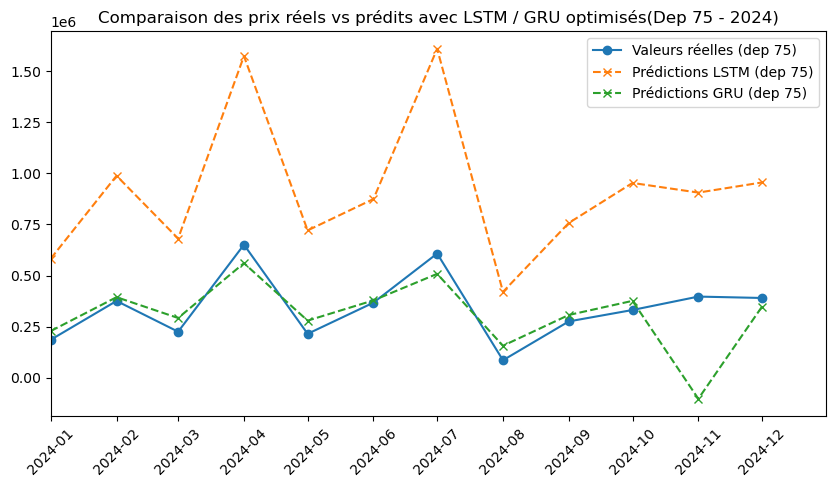

In [138]:
df_test_trimmed = df_test.iloc[timesteps:].copy()
df_test_trimmed["pred_lstm_opt"] = y_pred_lstm_opt.flatten()
df_test_trimmed["pred_gru_opt"] = y_pred_gru_opt.flatten()

df_monthly = df_test_trimmed.select_dtypes(include='number').resample('MS').mean()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly["prix_m2_vente"], label="Valeurs réelles (dep 75)", marker="o")
plt.plot(df_monthly.index, df_monthly["pred_lstm_opt"], label="Prédictions LSTM (dep 75)", linestyle="dashed", marker="x")
plt.plot(df_monthly.index, df_monthly["pred_gru_opt"], label="Prédictions GRU (dep 75)", linestyle="dashed", marker="x")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec LSTM / GRU optimisés(Dep 75 - 2024)")
plt.xticks(rotation=45)
plt.show();

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.01)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))